# 1. Tool import & Data Load

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import roc_auc_score,classification_report, recall_score, f1_score,precision_recall_curve, auc,precision_score,roc_curve,confusion_matrix
import multiprocessing
from pycaret.classification import *
from sklearn.linear_model import LassoCV
import seaborn as sns
sns.set(font="AppleGothic",  # Mac 환경일 경우
        # font="Malgun Gothic",  # Windows 환경일 경우
        rc={"axes.unicode_minus": False})  # 마이너스 폰트 깨지는 문제 대처

In [2]:
# 정밀도 vs 재현율 그래프 그리기 위한 함수 정의
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # thredshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출 
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 thredshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시 
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label ='recall')
    
    #thredshold 값 X축 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    #X축, y축, label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

In [3]:
df = pd.read_csv('Data_preprocessing_v4.csv')

In [4]:
df.shape

(23107, 20)

In [5]:
df.head()

,id,AGE,ALCSTAT,ARTH1,BMI,CHLEV,EPHEV,FSBALANC,GENDER,HISPAN_I,HYPEV,HYPMDEV2,HYPMED2,INTIL2W,MRACBPI2,MRACRPI2,REGION,HEIGHT(cm),WEIGHT(kg),DIBEV1
0,100011,79.0,0.0,1.0,23.594147,1.0,0.0,0,1.0,12.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,157.48,58.513368,1
1,100061,37.0,0.0,0.0,32.775484,1.0,0.0,0,0.0,12.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,180.34,106.594120,0
2,100091,75.0,0.0,1.0,22.273536,1.0,0.0,1,0.0,12.0,1.0,1.0,1.0,0.0,7.0,11.0,3.0,167.64,62.595696,0
3,1000101,39.0,0.0,0.0,23.709925,0.0,0.0,0,0.0,12.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,180.34,77.110640,0
4,1000131,54.0,1.0,0.0,38.273579,1.0,0.0,0,1.0,12.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,165.10,104.326160,0


# 2. 학습 / 테스트 데이터 분리

In [6]:
X_tr, X_test, y_tr, y_test = train_test_split(df.drop(['id','DIBEV1'],axis=1),df['DIBEV1'],shuffle=True,test_size=0.05,stratify=df['DIBEV1'],random_state=123)

In [7]:
y_tr.value_counts()[0]/(y_tr.value_counts()[0]+y_tr.value_counts()[1])

0.8596874857637465

In [8]:
y_tr.value_counts()

0    18871
1     3080
Name: DIBEV1, dtype: int64

In [9]:
y_test.value_counts()

0    994
1    162
Name: DIBEV1, dtype: int64

In [10]:
X_tr.shape

(21951, 18)

In [11]:
X_test_org = X_test.copy()

# 3. 불균형 데이터 처리(언더샘플링)

In [12]:
sampler = RandomUnderSampler(random_state=123)

In [13]:
y_tr.value_counts()

0    18871
1     3080
Name: DIBEV1, dtype: int64

In [14]:
X_under , y_under = sampler.fit_resample(X_tr,y_tr)
print(y_under.value_counts())

0    3080
1    3080
Name: DIBEV1, dtype: int64


# 4. 수치형 변수 데이터 스케일링

In [15]:
# 스케일링을 적용할 컬럼 선정
num_col = ['AGE','BMI','HEIGHT(cm)','WEIGHT(kg)']

In [16]:
# 전체 데이터셋의 위 컬럼들에 대해 스케일링 fit 후 각 데이터셋 및 검증용 데이터셋에 transform 적용
for col in num_col:
    ss = StandardScaler()
    X_under[col] = ss.fit_transform(X_under[[col]])
    X_test[col] = ss.transform(X_test[[col]])

# 5. 범주형 변수 onehotencoding

In [17]:
# 데이터프레임 전체 컬럼에서 수치형 컬럼 제외
cols = np.setdiff1d(X_under.columns,num_col)

# 위 컬럼에서 고유값 개수가 3개 이상인 컬럼만 추출
# 0,1만 가지는 binary 컬럼은 굳이 ohe를 하지 않을 것
nom_col = [col for col in cols if X_under[col].nunique() >= 3 ]

In [18]:
nom_col

['HISPAN_I', 'MRACBPI2', 'MRACRPI2', 'REGION']

In [19]:
# 명목형 컬럼들에 대한 dummy 데이터 생성(원핫인코딩)
train_dummies = [] # 학습용 데이터셋의 명목형 컬럼들의 더미데이터셋 저장용 리스트
test_dummies = [] # 검증용 데이터셋의 명목형 컬럼들의 더미데이터셋 저장용 리스트
for col in nom_col:
    train_dummies.append(pd.get_dummies(X_under[col],prefix=col,dtype='int')) # 학습데이터의 각 컬럼들의 더미데이터셋을 리스트에 저장
    test_dummies.append(pd.get_dummies(X_test[col],prefix=col,dtype='int')) # 검증데이터의 각 컬럼들의 더미데이터셋을 리스트에 저장

In [20]:
train_dummies = pd.concat(train_dummies,axis=1) # 학습 데이터의 더미데이터셋 리스트를 하나로 합침
test_dummies = pd.concat(test_dummies,axis=1) # 검증 데이터의 더미데이터셋 리스트를 하나로 합침

In [21]:
train_dummies.shape, test_dummies.shape

((6160, 31), (1156, 30))

In [22]:
# 만약 고유값 개수 차이로 인해 학습셋과 테스트셋의 더미 데이터셋 컬럼 차이가 있다면 컬럼수를 통일
# 학습 및 예측 오류 방지

if train_dummies.columns.nunique() > test_dummies.columns.nunique():
    missing_cols = set(train_dummies.columns) - set(test_dummies.columns)
    for col in missing_cols:
        test_dummies[col] = 0
elif train_dummies.columns.nunique() < test_dummies.columns.nunique():
    missing_cols = set(test_dummies.columns) - set(train_dummies.columns)
    for col in missing_cols:
        train_dummies[col] = 0
else:
    pass

In [23]:
train_dummies.shape, test_dummies.shape

((6160, 31), (1156, 31))

In [24]:
# 원본의 학습,테스트셋에 더미데이터셋 합친 후 기존 명목형 컬럼 제거
X_under = pd.concat([X_under,train_dummies],axis=1).drop(nom_col,axis=1)
X_test = pd.concat([X_test,test_dummies],axis=1).drop(nom_col,axis=1)

In [25]:
X_under.shape, X_test.shape

((6160, 45), (1156, 45))

In [26]:
X_under.shape, y_under.shape

((6160, 45), (6160,))

# 6. 전처리 완료 후 학습 / 검증 데이터 분리

In [27]:
X_tr, X_val, y_tr, y_val = train_test_split(X_under,y_under,test_size=0.2,random_state=123,shuffle=True,stratify=y_under)

# 7. pycaret 최적화 모델링

In [50]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
clf = setup(data=X_tr,target=y_tr,preprocess=False,verbose=False,n_jobs=-1,session_id=123) # pycaret AutoML사용을 위한 초기화
best_5 = compare_models(fold=10, sort='auc',verbose=False,n_select=5) # pycaret에서 sort에 설정한 평가지표 기준으로 데이터셋에 최적화된 모델 선정(n_select = 1이 기본값이며, 이 값에 따라 선정되는 모델의 개수 변경 됨)
tuned_models = []
for model in best_5:
    tuned_model = tune_model(model,optimize='auc',verbose=False,search_library='optuna',fold=skf)#,search_algorithm='optuna')
    tuned_models.append(tuned_model)

ensemble_model = blend_models(estimator_list=tuned_models, method='auto',optimize='auc',verbose=False) # best_5 모델들에 대한 앙상블

In [51]:
ensemble_model

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=0.2543938168447833,
                                                 class_weight={}, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('Linear Discriminant Analysis',
                              LinearDiscriminantA...
                                                     max_depth=6,
                                                     max_features=0.7860799347803318,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=1.057936121248065e-09,
                                                     min_samples_leaf=5,
                                                     min_samples_split=3,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=300,
                                                     n_jobs=-1, oob_score=False,
                                                     random_state=123,
                                                     verbose=0,
                                                     warm_start=False))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=None)

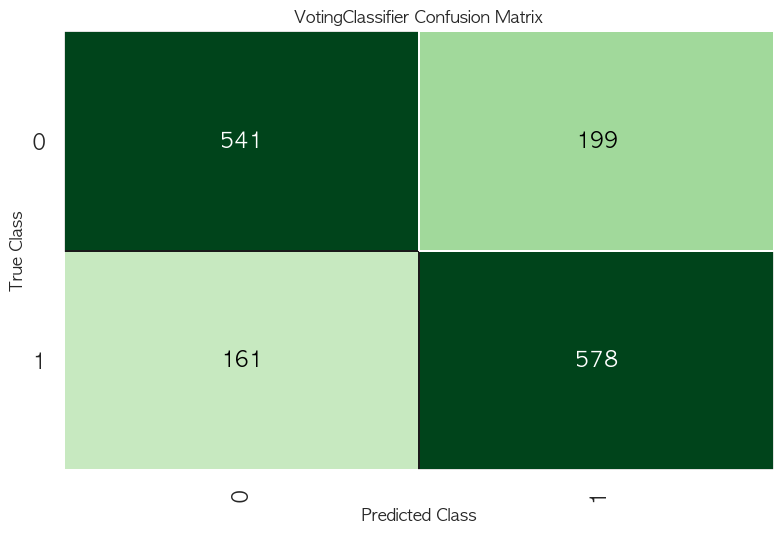

In [52]:
plot_model(ensemble_model,plot='confusion_matrix')

# 8. 검증데이터로 평가

In [53]:
# 검증 예측
pred = predict_model(ensemble_model,data=X_val,verbose=True)

In [54]:
pred

,AGE,ALCSTAT,ARTH1,BMI,CHLEV,EPHEV,FSBALANC,GENDER,HYPEV,HYPMDEV2,...,MRACRPI2_11.0,MRACRPI2_15.0,MRACRPI2_16.0,MRACRPI2_17.0,REGION_1.0,REGION_2.0,REGION_3.0,REGION_4.0,prediction_label,prediction_score
19619,0.669264,1.0,1.0,0.752928,1.0,0.0,1,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,1,0.8938
14468,0.839627,1.0,1.0,-0.394781,1.0,0.0,0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,1,0.8417
14109,-0.807214,0.0,0.0,-1.277502,0.0,0.0,0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,1,0,0.5278
21532,-0.125763,0.0,1.0,-0.166559,0.0,0.0,0,0.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0.5279
10648,-2.056542,1.0,0.0,-0.721475,0.0,0.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0.8426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8911,1.009990,0.0,1.0,-0.440649,1.0,1.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0.5137
17248,1.066778,1.0,0.0,-0.668373,0.0,0.0,0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,1,0.5652
15178,-0.750427,1.0,0.0,1.021610,0.0,0.0,0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0.6386
490,0.271751,0.0,0.0,-0.299887,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0.7673


In [55]:
# 실제값 과 예측값 비교
print(classification_report(y_val,pred['prediction_label']))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       616
           1       0.74      0.78      0.76       616

    accuracy                           0.76      1232
   macro avg       0.76      0.76      0.76      1232
weighted avg       0.76      0.76      0.76      1232



In [56]:
precision_score(y_val,pred['prediction_label'])

0.7441860465116279

In [57]:
recall_score(y_val,pred['prediction_label'])

0.7792207792207793

## 8-1. 검증 데이터 기준 임계값 결정 

In [58]:
pred['predict_proba'] = pred['prediction_score']
pred.loc[pred['prediction_label']==0,'predict_proba'] = 1-pred.loc[pred['prediction_label']==0,'predict_proba']

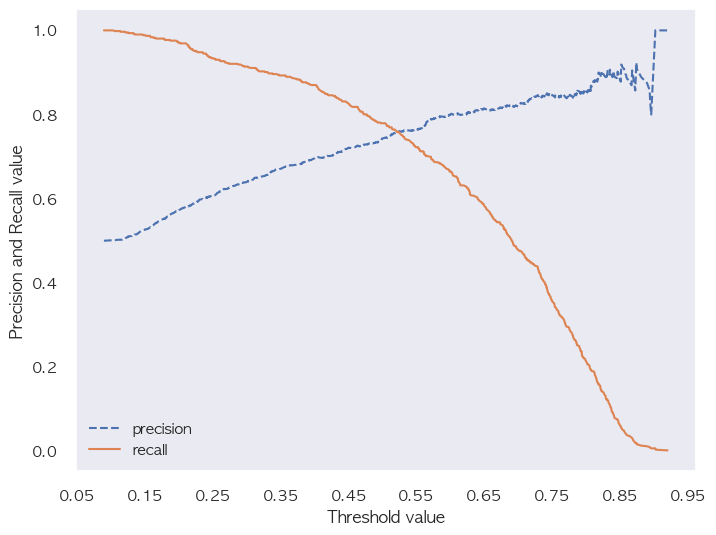

In [59]:
precision_recall_curve_plot(y_val,pred['predict_proba'])

In [60]:
f1_score_list = []
threshold_list = []
for j in range(10):
    j = 0.45+j*0.01
    # j = 0.485
    result = [0 if i<=j else 1 for i in pred['predict_proba']]
    score = f1_score(y_val,result)
    f1_score_list.append(score)
    threshold_list.append(j)
    print(f'임계값:{j} / f1_score : {round(score,3)} / recall : {round(recall_score(y_val,result),3)} / precision : {round(precision_score(y_val,result),3)}')

임계값:0.45 / f1_score : 0.769 / recall : 0.825 / precision : 0.721
임계값:0.46 / f1_score : 0.768 / recall : 0.818 / precision : 0.723
임계값:0.47000000000000003 / f1_score : 0.765 / recall : 0.807 / precision : 0.728
임계값:0.48 / f1_score : 0.762 / recall : 0.795 / precision : 0.731
임계값:0.49 / f1_score : 0.758 / recall : 0.784 / precision : 0.734
임계값:0.5 / f1_score : 0.761 / recall : 0.779 / precision : 0.744
임계값:0.51 / f1_score : 0.759 / recall : 0.769 / precision : 0.749
임계값:0.52 / f1_score : 0.76 / recall : 0.761 / precision : 0.759
임계값:0.53 / f1_score : 0.755 / recall : 0.748 / precision : 0.761
임계값:0.54 / f1_score : 0.749 / recall : 0.737 / precision : 0.762


In [61]:
j = 0.5
# j = 0.485
result = [0 if i<=j else 1 for i in pred['predict_proba']]
score = f1_score(y_val,result)
f1_score_list.append(score)
threshold_list.append(j)
print(f'임계값:{j} / f1_score : {round(score,3)} / recall : {round(recall_score(y_val,result),3)} / precision : {round(precision_score(y_val,result),3)}')

임계값:0.5 / f1_score : 0.761 / recall : 0.779 / precision : 0.744


In [62]:
ensemble_model.set_params

<bound method _BaseHeterogeneousEnsemble.set_params of VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=0.2543938168447833,
                                                 class_weight={}, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('Linear Discriminant Analysis',
                              LinearDiscriminantA...
                                         

# 9. 테스트 데이터 예측

In [63]:
# 검증 예측
pred = predict_model(ensemble_model,data=X_test,verbose=True)

In [64]:
pred

,AGE,ALCSTAT,ARTH1,BMI,CHLEV,EPHEV,FSBALANC,GENDER,HYPEV,HYPMDEV2,...,MRACRPI2_15.0,MRACRPI2_16.0,MRACRPI2_17.0,REGION_1.0,REGION_2.0,REGION_3.0,REGION_4.0,HISPAN_I_8.0,prediction_label,prediction_score
14291,0.555689,0.0,1.0,-0.687276,0.0,1.0,0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,1,0.5508
10264,-0.012187,0.0,0.0,-1.181572,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0.8153
22816,0.555689,0.0,1.0,-0.262287,1.0,0.0,0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,1,0.7315
13409,0.669264,1.0,0.0,-0.657759,0.0,0.0,0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0.7075
4533,0.385326,0.0,0.0,-0.125871,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0.7349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10194,-1.772604,0.0,0.0,-0.400411,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0.8714
12345,-0.239338,0.0,0.0,0.387761,0.0,0.0,0,1.0,1.0,1.0,...,0,0,0,1,0,0,0,0,1,0.5864
11886,-0.409701,0.0,1.0,2.138274,1.0,0.0,0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,1,0.7876
21850,-1.942967,0.0,0.0,-1.430842,0.0,0.0,0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0.9022


# 9-1. 테스트 데이터 예측값(확률) 정리

In [65]:
# 각 test데이터 별 결정 된 label마다의 확률이 저장 된 prediction_score를 기반으로 label 0,1 중 1에 대한 확률값을 가진 컬럼 정의 
pred['predict_proba'] = pred['prediction_score']
pred.loc[pred['prediction_label']==0,'predict_proba'] = 1-pred.loc[pred['prediction_label']==0,'predict_proba']

## 9-2. 예측 확률값을 임계값 기준으로 최종 예측 값 정리

In [66]:
result = [0 if i<=j else 1 for i in pred['predict_proba']]

In [67]:
# 실제값 과 예측값 비교
print(classification_report(y_test,result))

              precision    recall  f1-score   support

           0       0.95      0.71      0.81       994
           1       0.30      0.76      0.43       162

    accuracy                           0.72      1156
   macro avg       0.62      0.74      0.62      1156
weighted avg       0.86      0.72      0.76      1156



# 10. 예측 결과 시각화

## 10-1. 변수 중요도 시각화

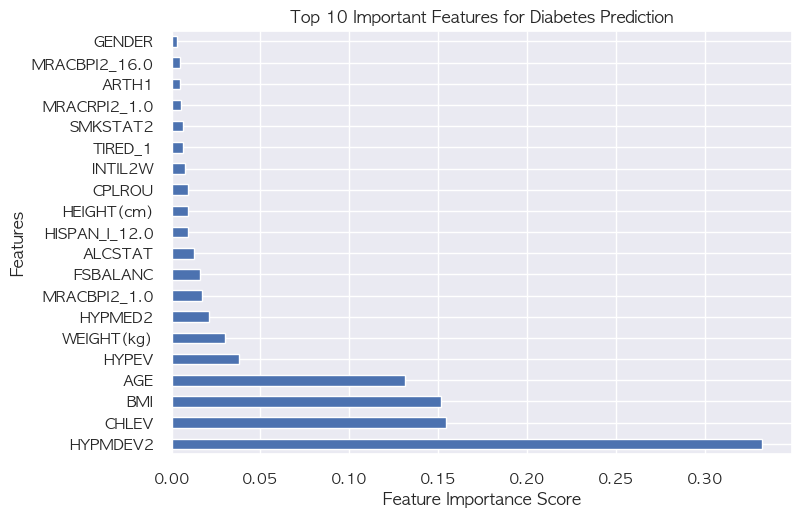

In [45]:
feature_importance = pd.Series(tuned_models[2].feature_importances_, index=tuned_models[2].feature_names_in_)

feature_importance.nlargest(20).plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Diabetes Prediction')
plt.show()

변수들 중 당뇨와 연관이 있는 컬럼은

HYPMDEV2_0.0(1.0) & HYPMED2_0.0(1.0) : 과거 혈압약 복용 유무 / 혈압약 복용 유무

BMI(WEIGHT(kg) / HEIGHT(cm)) : BMI

AGE : 나이

CHLEV_0.0(1.0) : 콜레스테롤이 높다고 진단 받은적이 있는 지 유무

MRACBPI2_1 : 인종 관련으로 1번은 백인종 / 미국내 당뇨 환자 중 히스패닉/아시아인 순서로 당뇨 환자수가 높다고 알려져 있어 인종 변수를 선택했으나 변수 영향력으로는 백인이 높은 것을 볼 수 있음

FSBALANC_1 : 균형 잡힌 식사를 하는지에 대한 유무로 1은 균형잡힌 식사를 하지 못하는 것을 의미

HISPAN_I_12 : 히스패닉 인종에 대한 컬럼으로 12번은 히스패닉이 아니며/ 스페인 사람을 의미 / 위의 인종 변수와 마찬가지로 미국내 히스패닉 계열이 당뇨 환자수가 많다고 알려져 있어 선택했으나 변수 영향력으로는 히스패닉이 아닌 사람이 변수 영향력이 높음

## 10-2. 변수 중요도 top 5에 대한 당뇨 분포 차이

In [72]:
feature_importance.nlargest(8).index

Index(['HYPMDEV2', 'CHLEV', 'BMI', 'AGE', 'HYPEV', 'WEIGHT(kg)', 'HYPMED2',
       'MRACBPI2_1.0'],
      dtype='object')

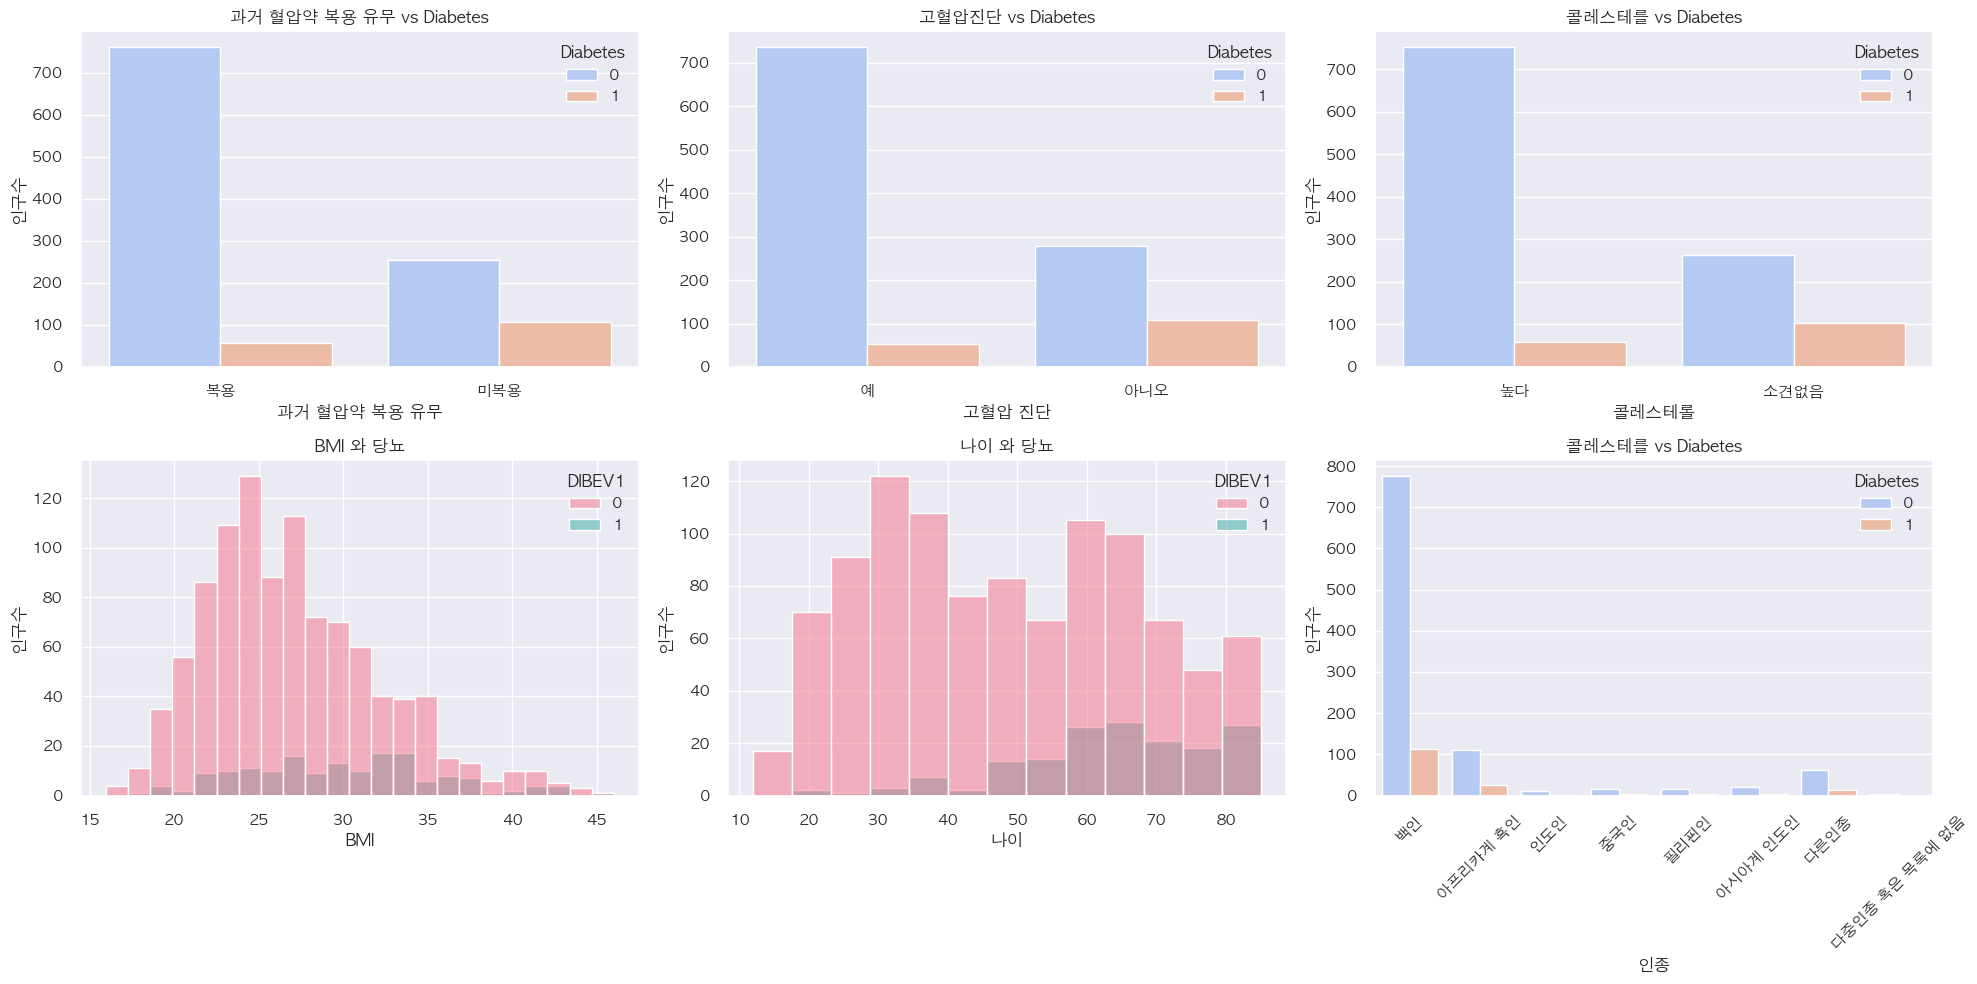

In [80]:
X_test_org['DIBEV1'] = y_test

plt.figure(figsize=(20, 10))

#혈압약 복용 이력 과 당뇨
plt.subplot(2, 3, 1)
sns.countplot(x='HYPMDEV2', hue='DIBEV1', data=X_test_org, palette='coolwarm')
plt.xlabel('과거 혈압약 복용 유무')
plt.xticks(ticks=[0, 1], labels=['복용', '미복용'])
plt.ylabel('인구수')
plt.title(f'과거 혈압약 복용 유무 vs Diabetes')
plt.legend(title='Diabetes', loc='best')

#고혈압 진단과 당뇨
plt.subplot(2, 3, 2)
sns.countplot(x='HYPEV', hue='DIBEV1', data=X_test_org, palette='coolwarm')
plt.xlabel('고혈압 진단')
plt.xticks(ticks=[0, 1], labels=['예', '아니오'])
plt.ylabel('인구수')
plt.title(f'고혈압진단 vs Diabetes')
plt.legend(title='Diabetes', loc='best')

#콜레스테롤과 당뇨
plt.subplot(2, 3, 3)
sns.countplot(x='CHLEV', hue='DIBEV1', data=X_test_org, palette='coolwarm')
plt.xlabel('콜레스테롤')
plt.xticks(ticks=[0, 1], labels=['높다', '소견없음'])
plt.ylabel('인구수')
plt.title(f'콜레스테를 vs Diabetes')
plt.legend(title='Diabetes', loc='best')


#BMI와 당뇨
plt.subplot(2, 3, 4)
sns.histplot(data=X_test_org, x='BMI', hue='DIBEV1', fill=True, palette='husl')
plt.title('BMI 와 당뇨')
plt.xlabel('BMI')
plt.ylabel('인구수')

#나이와 당뇨
plt.subplot(2, 3, 5)
sns.histplot(data=X_test_org, x='AGE', hue='DIBEV1', fill=True, palette='husl')
plt.title('나이 와 당뇨')
plt.xlabel('나이')
plt.ylabel('인구수')

#인종과 당뇨
plt.subplot(2, 3, 6)
sns.countplot(x='MRACBPI2', hue='DIBEV1', data=X_test_org, palette='coolwarm')
plt.xlabel('인종')
plt.xticks(ticks=np.arange(8), labels=['백인','아프리카계 흑인','인도인','중국인','필리핀인','아시아계 인도인','다른인종','다중인종 혹은 목록에 없음'],rotation=45)
plt.ylabel('인구수')
plt.title(f'콜레스테를 vs Diabetes')
plt.legend(title='Diabetes', loc='best')


plt.tight_layout()
plt.show()

## 10-3. 실제값 vs 예측값 시각화

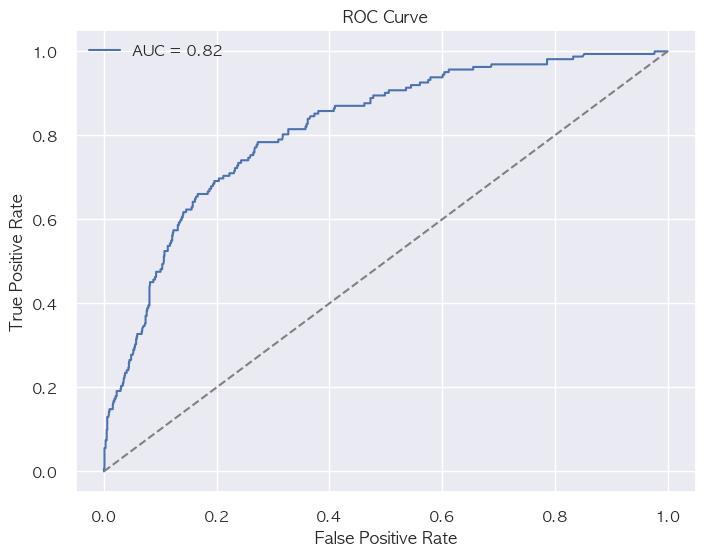

In [46]:
# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, pred['predict_proba'])
auc = roc_auc_score(y_test, pred['predict_proba'])

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


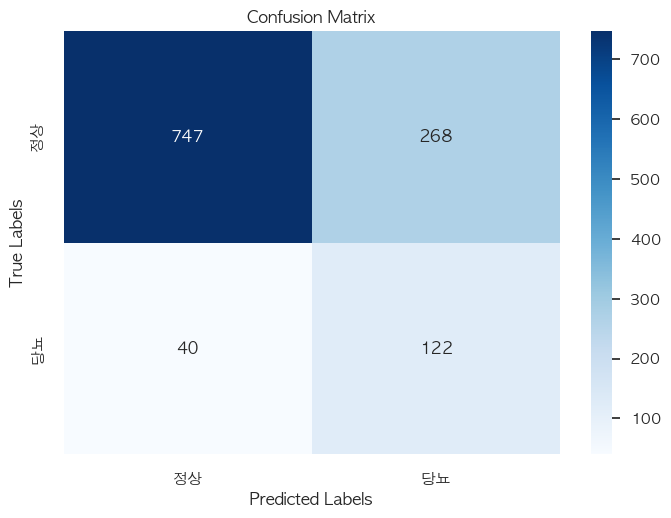

In [47]:
# 혼동 행렬 생성
cm = confusion_matrix(y_test, result)

# 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['정상','당뇨'],yticklabels=['정상','당뇨'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
result_str = ['정상' if i==0 else '당뇨' for i in result]
y_test_str = ['정상' if i==0 else '당뇨' for i in y_test]

In [49]:
print(classification_report(y_test_str,result_str))

              precision    recall  f1-score   support

          당뇨       0.31      0.75      0.44       162
          정상       0.95      0.74      0.83      1015

    accuracy                           0.74      1177
   macro avg       0.63      0.74      0.64      1177
weighted avg       0.86      0.74      0.78      1177



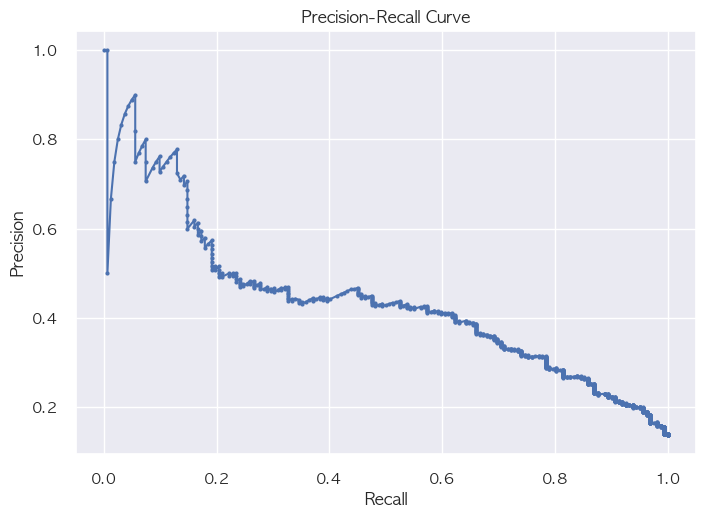

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, pred['predict_proba'])

# Precision-Recall Curve 시각화
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()